# Introduction

* Thoughts on improve the profitability
> Should find pairs with stronger relationship
>
> Should use some other econometrics model to calculate the spread (?Can we use something other than OLS?)

This notebook aims for providing an experiment of traditional pair trading with parameter autotuning grid search.

This experiment is based on [backtrader](https://www.backtrader.com/) which has an agnosticism philosophy that the data come in as a per-sample basis. Indicators are recalculate when new data come in.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pyfolio
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import backtrader as bt

from tqdm import tqdm
from itertools import combinations
from utils.gridsearch import gridsearch
from utils.read2df import read2df
from utils.cointncorr import CointnCorr
from utils.resanalyse import res_analyse
from utils.pyfolioprocess import pyfolio_process
from envs.env_gridsearch import KellyCriterionIndicator, PairTrading

os.makedirs("result/gridsearch", exist_ok=True)

cointncorrtxt = f"result/gridsearch/cointncorr.txt"
os.remove(cointncorrtxt) if os.path.exists(cointncorrtxt) else None

for root, dirs, files in os.walk(f"result/gridsearch/"):
    for file in files:
        os.remove(os.path.join(root, file))

# Data Preparation

Download historical data for `symbols` after `start_date` with selected `freqs` from [`binance-public-data`](https://github.com/binance/binance-public-data/tree/master/python)

We will train data from `start_date` until `trade_date`, and start trade after `trade_date`.

In [2]:
# symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XMRUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'SOLUSDT', 'TRXUSDT']
symbols = ['BTCUSDT', 'BTCUSD', 'BTCTUSD', 'BTCUSDC', 'BTCBUSD', 'BTCDAI']
# symbols = ['USDCUSDT', 'DAIUSDT', 'TUSDUSDT', 'BUSDUSDT', 'USDCTUSD', 'USDCBUSD', 'DAIBUSD', 'TUSDBUSD', 'BUSDDAI']
start_date = '2022-01-01'
trade_date = '2023-01-01'

# freqs = {'1h':60, '2h':120, '4h':240, '6h':360, '8h':480, '12h':720, '1d':1440}
freqs = {'3m':3, '5m':5, '15m':15, '30m':30}

In [3]:
%%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py \
        -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py \
        -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

In [4]:
'''
Read the downloaded OHLCV data into `pandas` dataframe
'''

# dfs = read2df(symbols, freqs)
dfs = read2df(symbols, freqs)

# have a preview
dfs[0]

,time,open,high,low,close,volume,tic,itvl,datetime
0,1609459379999,28961.73,29051.37,28950.71,29028.11,32.783596,BTCBUSD,3m,2021-01-01 00:02:59.999
1,1609459379999,28831.57,28917.25,28801.19,28885.74,0.187694,BTCDAI,3m,2021-01-01 00:02:59.999
2,1609459379999,29034.97,29040.69,29019.82,29019.82,0.250102,BTCTUSD,3m,2021-01-01 00:02:59.999
3,1609459379999,28964.54,29064.55,28958.66,29033.05,6.625958,BTCUSDC,3m,2021-01-01 00:02:59.999
4,1609459379999,28923.63,29017.50,28913.12,28989.30,128.404862,BTCUSDT,3m,2021-01-01 00:02:59.999
...,...,...,...,...,...,...,...,...,...
2085845,1698796799999,34648.10,34664.70,34641.51,34643.94,0.402040,BTCBUSD,3m,2023-10-31 23:59:59.999
2085846,1698796799999,34667.04,34675.74,34643.61,34643.61,0.034160,BTCDAI,3m,2023-10-31 23:59:59.999
2085847,1698796799999,34645.96,34662.58,34645.96,34648.08,3.798230,BTCTUSD,3m,2023-10-31 23:59:59.999
2085848,1698796799999,34663.44,34676.41,34656.42,34656.42,0.229680,BTCUSDC,3m,2023-10-31 23:59:59.999


In [5]:
'''
Set data before `trade_data` as training data, after `trade_data` is trade_data
'''

trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][dfs[i]['datetime'] >= trade_date].reset_index(drop=True))

# Cointegration and Correlation

We need to make sure that our data is capable for pair trading. 
At least it should have the tendency to merge together therefore we test the coint and corr between every possible two pairs 

Calculate daily coint and corr for all the pairs
Consider 1 day with 1440 minutes.

Delete the pickle file in the `\result` if want to recalculate

In [6]:
'''
Load data from pickle or recalculate
'''

import pickle

# If there is already a pickle file
pickle_file = 'result/cointncorr.pickle'

if os.path.exists(pickle_file):
    with open('result/cointncorr.pickle', 'rb') as pk:
        data = pickle.load(pk)

    freq_position = list(freqs.keys()).index(data[1])

    df0 = dfs[freq_position][dfs[freq_position]['tic']==data[0][0]].reset_index(drop=True)
    df1 = dfs[freq_position][dfs[freq_position]['tic']==data[0][1]].reset_index(drop=True)

    pair, best_freq = data 
    best_pair = f"{pair[0]}_{pair[1]}"

    print("===========================================")
    print(f"Data loaded as: {best_pair} under {best_freq} interval")
    print("===========================================")

else: 
    # If there is no pickle file, then recalculate
    # Takes a looooong time
    tables = CointnCorr(trains, freqs).tabulate()

    with open(cointncorrtxt, "a") as f:
        for k, v in tables.items():
            f.write(f"{k}\n")
            f.write(f"{v}\n\n")
    f.close()

    best_value = 0
    for key in tables.keys():
        for freq in freqs:
            rel = tables[key].at['coint', freq] + tables[key].at['corr', freq]
            if rel > best_value:
                best_value = rel
                best_pair = key
                best_freq = freq

    print("===========================================")
    print(f"Best trading pairs shall be: {best_pair} under {best_freq} interval")
    print(f"the coint is {round(tables[best_pair].at['coint', best_freq]*100, 2)}%")
    print(f"and the corr is {round(tables[best_pair].at['corr', best_freq],3)}")
    print("===========================================")

Data loaded as: BTCBUSD_BTCTUSD under 3m interval


In [7]:
cointncorr = best_pair.split("_"), best_freq

with open('result/cointncorr.pickle', 'wb') as pk:
    pickle.dump(cointncorr, pk)
    
freq_pos = list(freqs.keys()).index(best_freq)

traindata0 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
traindata1 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

# How come a datetime of 2022(ish) is converted to 738786.635416655???
datafeed0 = bt.feeds.PandasData(
        dataname=traindata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeed1 = bt.feeds.PandasData(
        dataname=traindata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeeds = [datafeed0, datafeed1]
print(f"length of train set is {len(traindata0)}")

length of train set is 130140


# Execute the Strategy

We should firstly have a test run on the strategy to make sure it works.

Submitted a PR for Backtrader-OLS results

> https://github.com/mementum/backtrader/pull/487

In [8]:
def cerebro_run(datafeeds, param):
    # Create a Cerebro instance and add the data feed
    cerebro = bt.Cerebro()
    # TODO: should I include `best_pair` as a parameter?
    cerebro.adddata(datafeeds[0], name=best_pair.split('_')[0])
    cerebro.adddata(datafeeds[1], name=best_pair.split('_')[1])

    # Set up other parameters for backtest
    cerebro.broker.set_cash(100000)  # Set initial capital
    # cerebro.broker.setcommission(commission=0.001) 

    # comminfo = PairTradingCommInfo(commission=0.002, margin=1000, mult=10)
    # cerebro.broker.addcommissioninfo(comminfo)

    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturns', compression=60)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
    # cerebro.addsizer(KellyCriterionSizer)

    cerebro.addstrategy(PairTrading, **param)
    strats = cerebro.run()
    return strats

In [9]:
# A test run
# https://github.com/mementum/backtrader/blob/master/backtrader/indicators/ols.py
# It always returns weird error like the number of params

# 1. The default OLS indicator is precarious, always weird errors like num of params, or sometimes index error
# 2. The custom indicator is precious as well. not trustworthy

param = {'OPEN_THRE':2, 'CLOS_THRE':0.1, 'period':1000, 'verbose':2, 'prefix':'Experiment'}
experiment = cerebro_run(datafeeds, param)


Open Threshold:2, Close Threshold:0.1, period: 1000

Starting Value - 100000.00

Ending   Value - 100252.30




# Grid Search the Strategy

The grid search on all the possible results for an optimal outcome

Define `scoring` function and `param_grid` for grid search

then `gridsearch` from `utils.gridsearch`

In [10]:
datafeeds = [datafeed0, datafeed1]
freq_adjust = freqs[best_freq]

'''
Seems longer period provides better result
I guess its because the zscore is relatively stabler
'''
param_grid = {
    'OPEN_THRE': [2.2], # np.arange(2.2, 2.3, 0.1), 
    'CLOS_THRE': [0.1], # np.arange(0.1, 0.1, 0.1), 
    'period': np.arange(int(1300/freq_adjust), int(1400/freq_adjust), int(100/freq_adjust)),
    'verbose': [0],
    'prefix': ['Gridsearch']
}

def scoring(strats):
    score = strats[0].analyzers.Returns.get_analysis()['rtot']
    return score

# included tqdm for progress bar
# Take a loooong time
best_profit, best_params, best_result = gridsearch(cerebro_run, param_grid, scoring, datafeeds)

print(f"Best parameters as: {best_params}")
print(f"Best profit as: {best_profit}")

100%|██████████| 1/1 [02:37<00:00, 157.76s/it]

Best parameters as: {'OPEN_THRE': 2.2, 'CLOS_THRE': 0.1, 'period': 433, 'verbose': 0, 'prefix': 'Gridsearch'}
Best profit as: 0.0031134771741435827


# Trade with test data
Use the parameter tra

In [11]:
freq_position = list(freqs.keys()).index(best_freq)

testdata0 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
testdata1 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

test_datafeed0 = bt.feeds.PandasData(
        dataname=testdata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

test_datafeed1 = bt.feeds.PandasData(
        dataname=testdata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
)

test_datafeeds = [test_datafeed0, test_datafeed1]

In [12]:
best_params['verbose']=2
best_params['prefix']= 'Test'
# test_res = cerebro_run(test_datafeeds, best_params)

test_res = cerebro_run(test_datafeeds, best_params)


Open Threshold:2.2, Close Threshold:0.1, period: 433

Starting Value - 100000.00

Ending   Value - 100339.22




# Analyze with [Pyfolio](https://pyfolio.ml4trading.io/api-reference.html)

#TODO: We need find a way to calculate the per arbitrage data!... or should we?

Default package has an known error issue out of lack of maintainence, requires to modify the package manually
> https://github.com/quantopian/pyfolio/issues/652

Created a github merge
> https://github.com/quantopian/pyfolio/pull/703

### Analyze the grid search result

Total orders count:2756
Won orders count:1525
Lost orders count:1231
Win/Loss order ratio: 1.238830219333875
Avg order pnl:0.1131469186619374
Avg order pnl won:1.5424709712539286
Avg order pnl lost:-1.6575429109097848
Avg long order pnl:0.1568011199750313
Avg short order pnl:0.06949271734884357


Start date,2022-01-01
End date,2022-09-29
Total months,12
,Backtest
Annual return,0.3%
Cumulative returns,0.3%
Annual volatility,0.0%
Sharpe ratio,7.39
Calmar ratio,44.03
Stability,0.97
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.01,2022-08-09,2022-08-10,2022-08-13,4
1,0.01,2022-09-20,2022-09-21,2022-09-26,5
2,0.00,2022-09-07,2022-09-09,2022-09-18,8
3,0.00,2022-07-10,2022-07-14,2022-07-22,10
4,0.00,2022-02-27,2022-03-02,2022-03-06,5


Stress Events,mean,min,max
New Normal,0.00%,-0.01%,0.01%


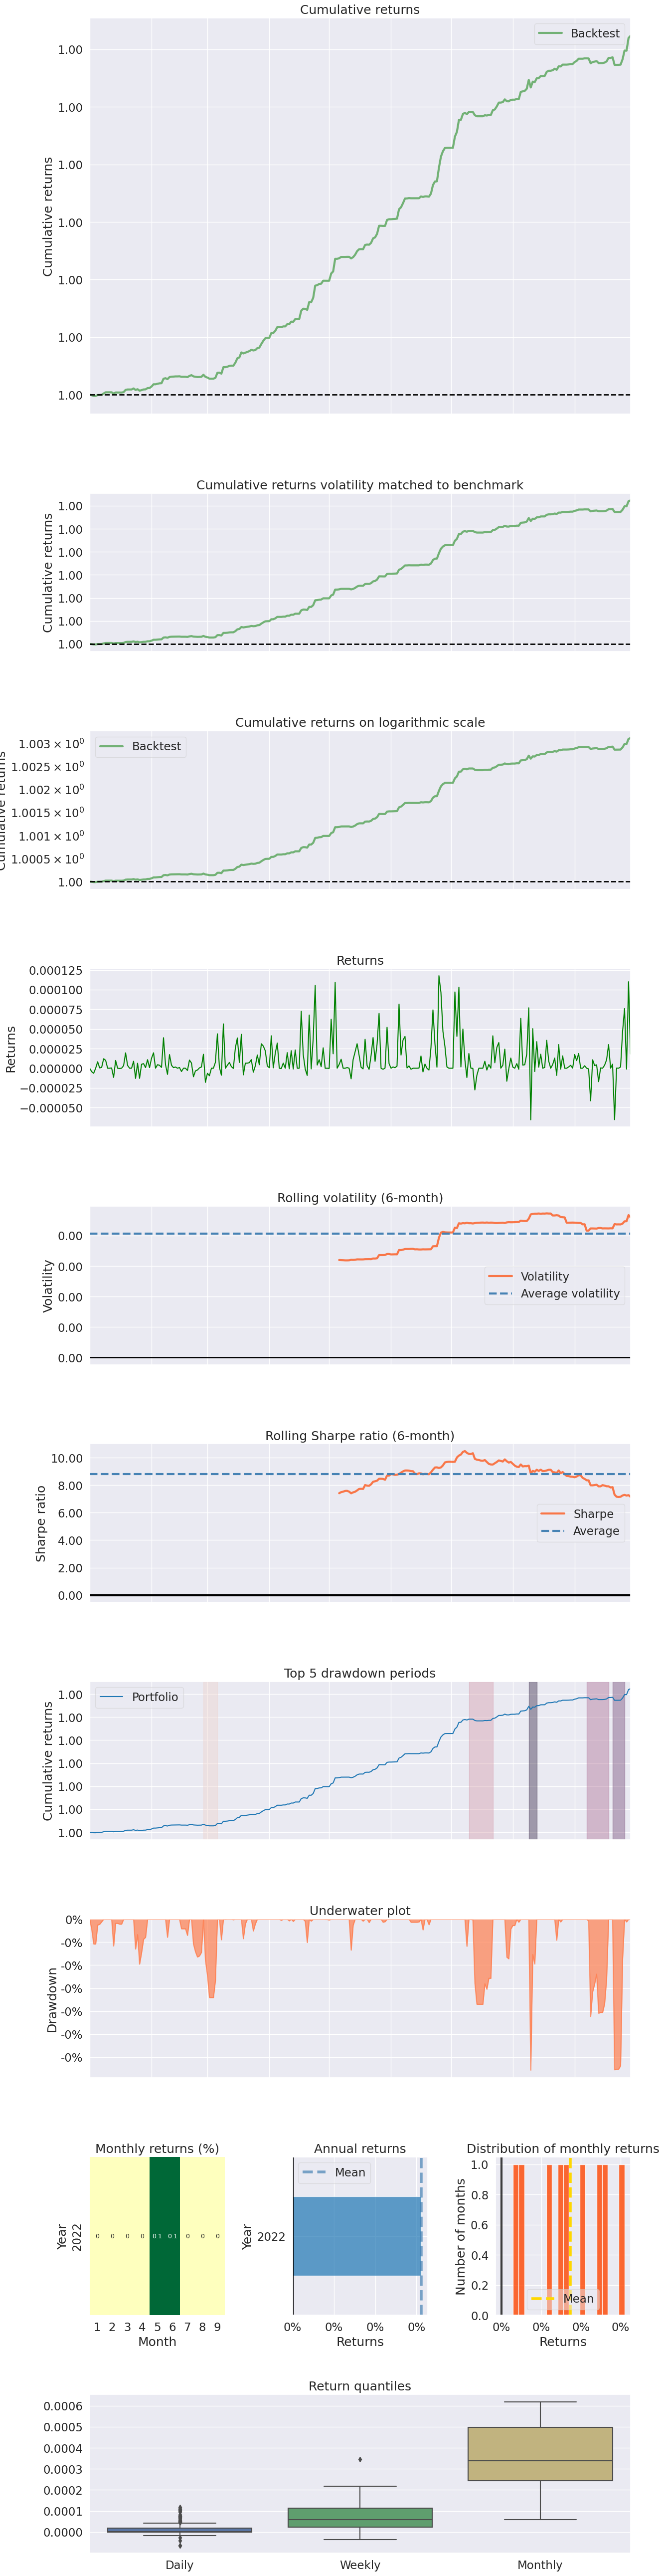

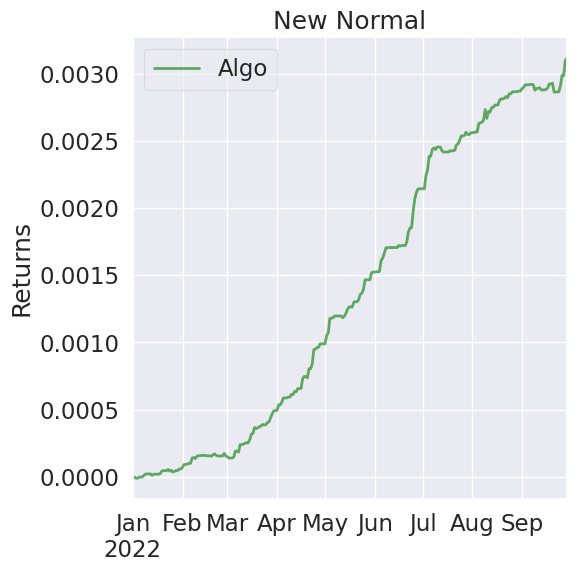

In [13]:
grid_tradeanalyzer = best_result[0].analyzers.tradeanalyzer.get_analysis()
res_analyse(grid_tradeanalyzer)

grid_pyfolio = pyfolio_process(best_result)
pyfolio.tears.create_full_tear_sheet(returns=pd.Series(grid_pyfolio))

### Analyze the test result

Total orders count:2056
Won orders count:1065
Lost orders count:991
Win/Loss order ratio: 1.0746720484359233
Avg order pnl:0.16498863853024104
Avg order pnl won:4.431204659260636
Avg order pnl lost:-4.41979447153824
Avg long order pnl:0.42144512198831074
Avg short order pnl:-0.09146784492782913


Start date,2023-03-12
End date,2023-10-31
Total months,11
,Backtest
Annual return,0.4%
Cumulative returns,0.3%
Annual volatility,0.1%
Sharpe ratio,5.36
Calmar ratio,24.56
Stability,0.97
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.01,2023-04-29,2023-04-30,2023-05-01,1
1,0.00,2023-10-18,2023-10-20,NaT,NaN
2,0.00,2023-06-15,2023-06-16,2023-06-18,2
3,0.00,2023-10-06,2023-10-07,2023-10-08,1
4,0.00,2023-10-12,2023-10-14,2023-10-15,2


Stress Events,mean,min,max
New Normal,0.00%,-0.01%,0.06%


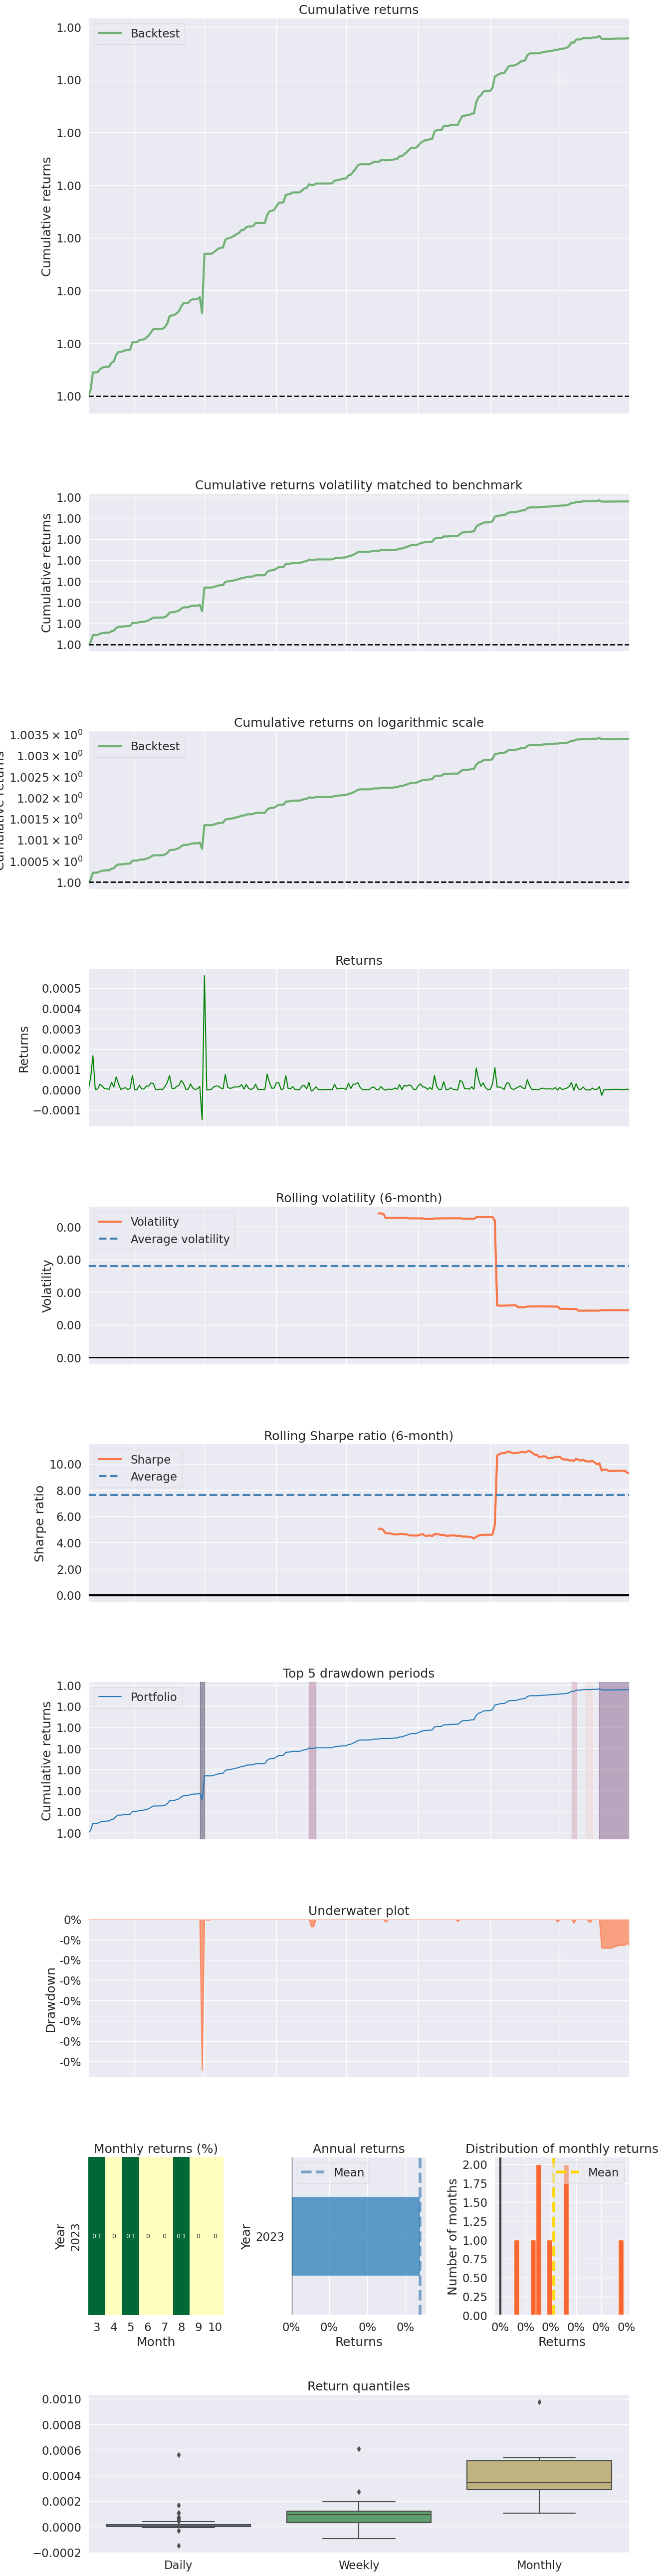

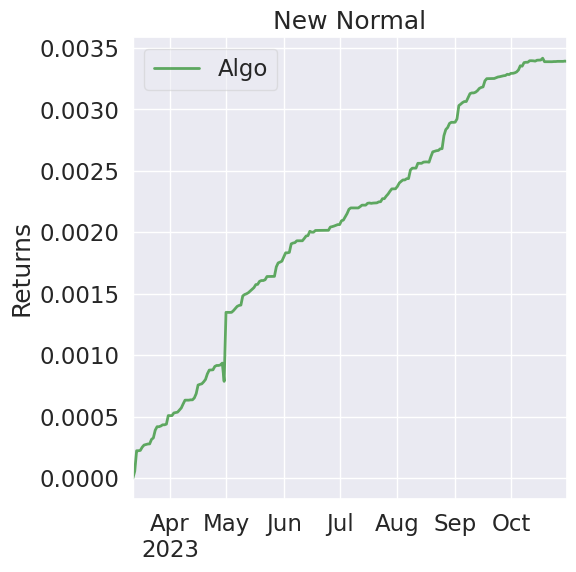

In [14]:
res_tradeanalyzer = test_res[0].analyzers.tradeanalyzer.get_analysis()
res_analyse(res_tradeanalyzer)

test_pyfolio = pyfolio_process(test_res)
pyfolio.tears.create_full_tear_sheet(returns=pd.Series(test_pyfolio))